# <center>Assignment 1 Implementation of two layer neural network
<center> youtao 18307110206

本报告使用jupyter notebook生成，实践代码（模型）见[GitHub repo](https://github.com/YT-bomb/DATA130051-Computer-Vision)，存储的模型及代码备份已上传至[Baidu Drive](https://pan.baidu.com/s/1T8uEwRxxPlasGAouOsriRw?pwd=1212)。此报告中将展示模型的代码结构以及展示模型的训练、存储、预测等细节，并展示模型参数的可视化。

## 代码框架说明

* ./model/data_load.py : 载入 tensorflow.keras 中的MNIST数据，并将其划分维指定数目的训练集、验证集和测试集
* ./model/optimizer.py : 定义了优化函数中的随机梯度下降SGD方法
* ./model/two_layers_net.py : 实现了仅使用 numpy 数组的两层神经网络，包括前向和反向传播
* ./model/model_train.py : 定义了训练模型的类， 以模型和训练所需的超参数作为输入，相应类函数可以进行模型训练和保存。
* ./model/visualize.py : 定义了将图像数据的4D进行可视化的函数

### 核心代码说明
##### 数据载入
从 tensorflow.keras 载入数据，并分割为训练集、验证集、测试集，具体见model/data_load.py。使用 get_MNIST_data() 获取数据：

In [1]:
from model.data_load import get_MNIST_data
data = get_MNIST_data()
for k, v in data.items():
    print('{}:'.format(k), v.shape)

X_train: (49000, 784)
y_train: (49000,)
X_val: (1000, 784)
y_val: (1000,)
X_test: (1000, 784)
y_test: (1000,)


可视化训练样本：

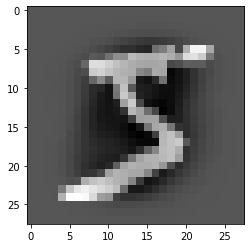

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot()
plt.imshow(np.reshape(data['X_train'][0], (28, 28)), cmap=plt.get_cmap('gray'))
plt.show()

##### 两层全连接神经网络实现，类属性及方法架构如下，详细见./model/two_layers_net.py

    class TwoLayerNet(object):
        """
            A two-layer fully connected network class.
            Assuming that the input dimension is D, the number of hidden units is H,
            the activation function is ReLU, and the output dimension is C (category C)

            input(D) - fully connected layer(H) - ReLU - fully connected layer(C) - softmax
            softmax layer may not be used when predict
        """
        def __init__(self, input_size=28*28, hidden_size=100, output_size=10, lam=0.0, std=1e-3):
            """
                --lam: 正则化强度
                --std: 用于随机初始化神经网络的参数
            """
            self.params = dict()
            # W1的维数为（D,H）；b1的维数为D
            self.params["W1"] = std * np.random.randn(input_size, hidden_size)
            self.params["b1"] = np.zeros((1, hidden_size))
            # W2的维数为（H,C）；b2的维数为C
            self.params["W2"] = std * np.random.randn(hidden_size, output_size)
            self.params["b2"] = np.zeros((1, output_size))
            self.lam = lam
        
        def forward(self, input, y=None):
            """
                if y is not None, return the loss and grads of the paras;
                else ruturn the result of the feature(not through softmax funcyion)
            """
            ...

        def loss(self, net_output, y, Batch_size,loss_type="entropy"):
            ...

        def L2_loss(self, lam):
            ...

        def ReLU(self, x):
            ...

        def predict(self, input):
            """
                retrun the label index of input data
            """
            ...

        def save_model(self, path):
            """
                --path: path where model saved
            """
            ...

        def load_model(self, path):
            """
                --path: path where model saved
                --return: a model object
            """
            ...

激活函数ReLU实现：

    def ReLU(self, x):
        return np.maximum(0, x)

Entropy loss 和 L2 正则化

    def loss(self, net_output, y, Batch_size,loss_type="entropy"):
        if loss_type == "entropy":
            # softmax function to calculate the probability
            output_max = np.max(net_output, axis=1, keepdims=True)
            exp_scores = np.exp(net_output - output_max)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Calculate the data cross-entropy loss
            entropy_loss = np.sum(-np.log(probs[range(Batch_size), y])) / Batch_size

            # calculate gradiant:
            d_output = probs
            d_output[range(Batch_size), y] -= 1
            d_output /= Batch_size

            return entropy_loss, d_output
        else:
            raise NotImplemented

    def L2_loss(self, lam):
        w1 = self.params["W1"]
        w2 = self.params["W2"]
        # calculate L2_loss:
        L2_loss = 0.5 * lam * (np.sum(w1 * w1) + np.sum(w2 * w2))
        # calculate gradiant:
        return L2_loss

前向传播计算以及反向传播计算梯度

    def forward(self, input, y=None):
        """
            if y is not None, return the loss and grads of the paras;
            else ruturn the result of the feature(not through softmax funcyion)
        """
        w1 = self.params["W1"]
        b1 = self.params["b1"]
        w2 = self.params["W2"]
        b2 = self.params["b2"]
        Batch_size, *_ = input.shape
        # h1: (N,h)
        h1 = np.dot(input, w1) + b1
        # ReLU
        h1 = self.ReLU(np.dot(input, w1) + b1)
        # output: (N,C)
        output = np.dot(h1, w2) + b2
        if y is None:
            return output

        entropy_loss, d_output = self.loss(output, y, Batch_size)
        L2_loss = self.L2_loss(self.lam)
        total_loss = entropy_loss + L2_loss

        """
            Backpropagation, calculate the gradiants of params
        """
        grads = {}
        grads["W2"] = self.lam * w2 + np.dot(h1.T, d_output)
        grads["b2"] = np.sum(d_output, axis=0, keepdims=True)

        # ReLU layer:
        dh1 = np.dot(d_output, w2.T)
        dh1[h1 <= 0] = 0

        grads["W1"] = np.dot(input.T, dh1) + self.lam * w1
        grads["b1"] = np.sum(dh1, axis=0, keepdims=True)

        return total_loss, grads

模型保存和加载：

    def save_model(self, path):
        """
            --path: path where model saved
        """
        obj = pickle.dumps(self)
        with open(path, "wb") as f:
            f.write(obj)

    def load_model(self, path):
        """
            --path: path where model saved
            --return: a model object
        """
        obj = None
        with open(path, "rb") as f:
            try:
                obj = pickle.load(f)
            except:
                print("IOError")
        return obj


##### 模型的训练
为方便模型训练，在./model/model_train.py中定义了训练模型的类 Training, 类架构如下：

    class Traning(object):

        def __init__(self, model, data, learning_rate=1e-3, gamma=0.95, batch_size=100, epochs=10, optimizer=sgd, save_checkpoint=True, checkpoint_name=None, detail=True):
            """
                --model: model for training
                --data: data used for training
                --learning_rate: initial learning rate for updating the params of model
                --gamma: Learning rate decay factor, dacay after each epoch
                --batch_size: nums of data used each training iteration
                --epochs
                --optimizer: optimizer used to update params
                --save_checkpoint: whether save checkpoint after each epoch training
                --checkpoint_name: used in _save_checkpoint
                --detail: whether print detail after each epoch
            """
            ...
        
        def _save_checkpoint(self):
            """ save checkpoint of train """
            ...
            
        def _load_checkpoint(self, path):
            """ load checkpoint to continue train """
            ...

        def accuracy(self, input, y, num_samples=None, batch_size=100):
            """
                Check accuracy of the model on the provided data.

                Inputs:
                -- input: Array of data, of shape (N, D)
                -- y: Array of labels, of shape (N,)
                -- num_samples: If not None, subsample the data and only test the model on num_samples datapoints.
                -- batch_size: Split input and y into batches of this size to avoid using
                too much memory.

                Returns:
                -- acc: Scalar giving the fraction of instances that were correctly classified by the model.
            """
            ...

        def train(self):
            """ begin training and save checkpoint according to self.save_checkpoint """
            ...

##### 优化算法实现：./model/optimizer.py

    def sgd(w, dw, learning_rate):
        w -= learning_rate * dw
        return w

### 模型生成、训练、保存
##### 使用定义的模型类 TwoLayerNet 和训练类 Training 进行模型生成和训练

In [1]:
from model.model_train import Traning
from model.two_layers_net import TwoLayerNet
from model.data_load import get_MNIST_data
from model.optimizer import sgd
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle
import os

In [3]:
input_size = 28*28
hidden_size = 100
output_size = 10
# 加载数据
data = get_MNIST_data()
# 创建模型，正则化强度为0.1
model = TwoLayerNet(input_size, hidden_size, output_size, lam=0.1)
Trainer = Traning(model=model, 
                data=data, 
                learning_rate=0.001, 
                gamma=0.95, 
                batch_size=100, 
                epochs=10, 
                optimizer=sgd, 
                save_checkpoint=True, 
                checkpoint_name="test",
                detail=True)

模型训练：

In [4]:
Trainer.train()

Epoch( 0 / 10) val loss: 2.3063663301817585	 val accuracy: 0.124
Epoch( 1 / 10) val loss: 0.34061818355669365	 val accuracy: 0.914
Saving checkpoint to "test_epoch_1.pkl"
Epoch( 2 / 10) val loss: 0.28133160136648383	 val accuracy: 0.925
Saving checkpoint to "test_epoch_2.pkl"
Epoch( 3 / 10) val loss: 0.24210602341609277	 val accuracy: 0.936
Saving checkpoint to "test_epoch_3.pkl"
Epoch( 4 / 10) val loss: 0.22326439222017833	 val accuracy: 0.945
Saving checkpoint to "test_epoch_4.pkl"
Epoch( 5 / 10) val loss: 0.21117941437452112	 val accuracy: 0.946
Saving checkpoint to "test_epoch_5.pkl"
Epoch( 6 / 10) val loss: 0.1993829378347002	 val accuracy: 0.953
Saving checkpoint to "test_epoch_6.pkl"
Epoch( 7 / 10) val loss: 0.20018078451561633	 val accuracy: 0.949
Saving checkpoint to "test_epoch_7.pkl"
Epoch( 8 / 10) val loss: 0.20110967835466473	 val accuracy: 0.95
Saving checkpoint to "test_epoch_8.pkl"
Epoch( 9 / 10) val loss: 0.20427822877278035	 val accuracy: 0.955
Saving checkpoint to "t

训练的loss以及模型可视化

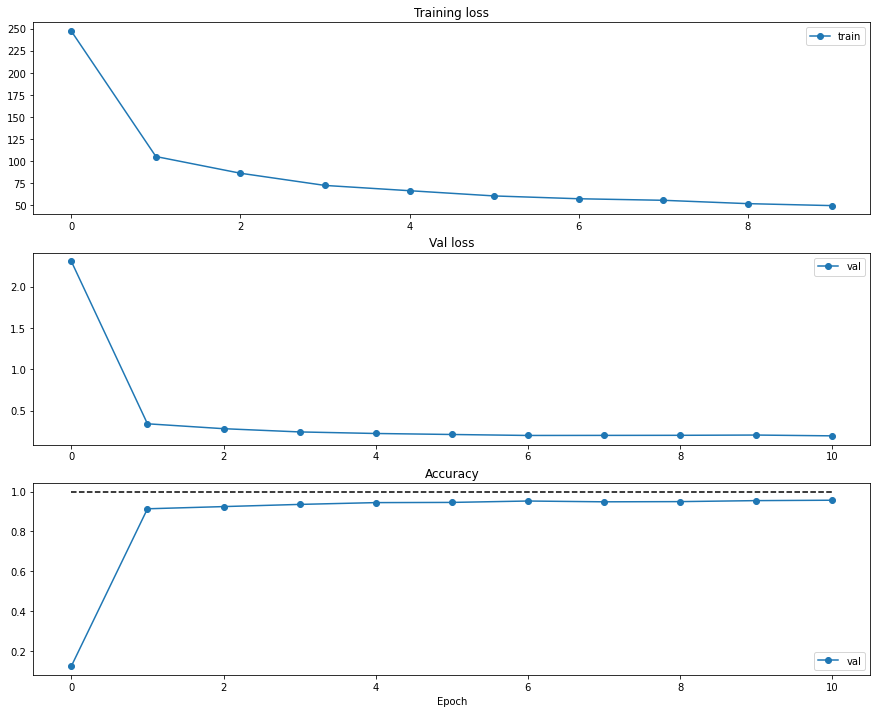

In [5]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.plot(Trainer.loss_history, '-o', label='train')
plt.legend(loc='upper right')
plt.subplot(3, 1, 2)
plt.title('Val loss')
plt.plot(Trainer.val_loss_history, '-o', label='val')
plt.legend(loc='upper right')
plt.subplot(3, 1, 3)
plt.title('Accuracy')
plt.plot(Trainer.val_acc_history, '-o', label='val')
plt.plot([1.0] * len(Trainer.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

网络参数可视化：

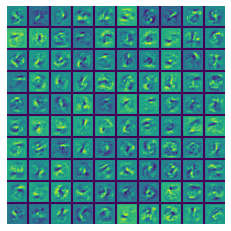

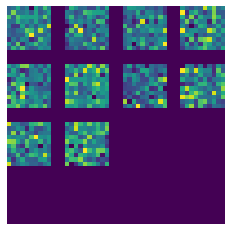

In [6]:
from model.visualize import visualize

# 可视化W1
W1 = Trainer.model.params["W1"].reshape(28, 28, 1, -1).transpose(3, 0, 1, 2)
plt.imshow(visualize(W1, padding=3).astype("uint8"))
plt.gca().axis("off")
plt.show()

# 可视化W1
W1 = Trainer.model.params["W2"].reshape(10, 10, 1, -1).transpose(3, 0, 1, 2)
plt.imshow(visualize(W1, padding=3).astype("uint8"))
plt.gca().axis("off")
plt.show()

模型保存：

In [7]:
Trainer.model.save_model("Test_model.model")

### 参数查找
对于隐藏层大小，学习率，正则化系数进行参数查找，寻找一个在验证集上表现最优的组合，并保存。

In [3]:
bestmodel = None
best_acc = 0
input_size = 28*28
output_size = 10
best_params = None
data = get_MNIST_data()
for i in range(10):
    hidden_size = random.choice([50, 80, 100, 150])
    lr = random.choice([5e-5, 1e-4, 5e-4, 1e-3])
    lam = random.choice([0.05, 0.1, 0.2])
    model = TwoLayerNet(input_size, hidden_size, output_size, lam)
    Trainer = Traning(model, data, lr, save_checkpoint=False, detail=False)
    Trainer.train()
    Val_acc = max(Trainer.val_acc_history)
    print(hidden_size, lr, lam, "------Val accuracy: ", Val_acc)
    if Val_acc>best_acc:
        best_acc = Val_acc
        bestmodel = Trainer.model
        best_params = (hidden_size, lr, lam)

print("Best params: ", best_params)

80 5e-05 0.05 ------Val accuracy:  0.887
100 0.001 0.05 ------Val accuracy:  0.957
100 0.0001 0.05 ------Val accuracy:  0.908
50 5e-05 0.1 ------Val accuracy:  0.886
50 0.001 0.05 ------Val accuracy:  0.952
50 0.0001 0.05 ------Val accuracy:  0.909
80 0.0005 0.05 ------Val accuracy:  0.952
50 0.0001 0.05 ------Val accuracy:  0.905
50 0.0005 0.05 ------Val accuracy:  0.947
100 5e-05 0.1 ------Val accuracy:  0.883
Best params:  (100, 0.001, 0.05)


模型保存

In [4]:
bestmodel.save_model("best_model.model")

### 模型测试
载入刚保存好的模型，使用该模型对测试集数据进行预测：

In [6]:
bsetmodel = TwoLayerNet().load_model("best_model.model")
# 验证集上的预测精度：
y_pred = bestmodel.predict(data["X_val"])
print("Accuracy on validation set: ", np.mean(y_pred == data["y_val"]))

Accuracy on validation set:  0.954


In [7]:
# 测试集上的预测精度：
y_pred = bestmodel.predict(data["X_test"])
print("Accuracy on test set: ", np.mean(y_pred == data["y_test"]))

Accuracy on test set:  0.977
